In [1]:
from google.cloud import vision
from google.protobuf import field_mask_pb2 as field_mask

from google.cloud import storage
from IPython.display import Image, display

import PIL

In [2]:
project_id = "google.com:ml-baguette-demos"
location = "europe-west1"

# Main methods

**Create product set**

In [3]:
def create_product_set(product_set_id, product_set_display_name):
    """
        product_set_id: Id of the product set.
        product_set_display_name: Display name of the product set.
    """
    client = vision.ProductSearchClient()

    # A resource that represents Google Cloud Platform location.
    location_path = f"projects/{project_id}/locations/{location}"

    # Create a product set with the product set specification in the region.
    product_set = vision.ProductSet(
            display_name=product_set_display_name)

    # The response is the product set with `name` populated.
    response = client.create_product_set(
        parent=location_path,
        product_set=product_set,
        product_set_id=product_set_id)

    # Display the product set information.
    print('Product set name: {}'.format(response.name))

**Create product**

In [4]:
def create_product(product_id, product_display_name, product_category):
    """
        product_id: Id of the product.
        product_display_name: Display name of the product.
        product_category: Category of the product.
    """
    client = vision.ProductSearchClient()

    # A resource that represents Google Cloud Platform location.
    location_path = f"projects/{project_id}/locations/{location}"

    # Create a product with the product specification in the region.
    # Set product display name and product category.
    product = vision.Product(
        display_name=product_display_name,
        product_category=product_category)

    # The response is the product with the `name` field populated.
    response = client.create_product(
        parent=location_path,
        product=product,
        product_id=product_id)

    # Display the product information.
    print('Product name: {}'.format(response.name))

**Add product to product set**

In [5]:
def add_product_to_product_set(product_id, product_set_id):
    """
        product_id: Id of the product.
        product_set_id: Id of the product set.
    """
    client = vision.ProductSearchClient()

    # Get the full path of the product set.
    product_set_path = client.product_set_path(
        project=project_id, location=location,
        product_set=product_set_id)

    # Get the full path of the product.
    product_path = client.product_path(
        project=project_id, location=location, product=product_id)

    # Add the product to the product set.
    client.add_product_to_product_set(
        name=product_set_path, product=product_path)
    print('Product added to product set.')

**Create reference image for product**

In [6]:
def create_reference_image(product_id, reference_image_id, gcs_uri):
    """
        product_id: Id of the product.
        reference_image_id: Id of the reference image.
        gcs_uri: Google Cloud Storage path of the input image.
    """
    client = vision.ProductSearchClient()

    # Get the full path of the product.
    product_path = client.product_path(
        project=project_id, location=location, product=product_id)

    # Create a reference image.
    reference_image = vision.ReferenceImage(uri=gcs_uri)

    # The response is the reference image with `name` populated.
    image = client.create_reference_image(
        parent=product_path,
        reference_image=reference_image,
        reference_image_id=reference_image_id)

    # Display the reference image information.
    print('Reference image name: {}'.format(image.name))
    print('Reference image uri: {}'.format(image.uri))

**Import products from csv import file in Cloud Storage to product set**

In [7]:
def import_product_sets(gcs_uri):
    """
        gcs_uri: Google Cloud Storage URI.
            Target files must be in Product Search CSV format.
    """
    client = vision.ProductSearchClient()

    # A resource that represents Google Cloud Platform location.
    location_path = f"projects/{project_id}/locations/{location}"

    # Set the input configuration along with Google Cloud Storage URI
    gcs_source = vision.ImportProductSetsGcsSource(
        csv_file_uri=gcs_uri)
    input_config = vision.ImportProductSetsInputConfig(
        gcs_source=gcs_source)

    # Import the product sets from the input URI.
    response = client.import_product_sets(
        parent=location_path, input_config=input_config)

    print('Processing operation name: {}'.format(response.operation.name))
    # synchronous check of operation status
    result = response.result()
    print('Processing done.')

    for i, status in enumerate(result.statuses):
        print('Status of processing line {} of the csv: {}'.format(
            i, status))
        # Check the status of reference image
        # `0` is the code for OK in google.rpc.Code.
        if status.code == 0:
            reference_image = result.reference_images[i]
            print(reference_image)
        else:
            print('Status code not OK: {}'.format(status.message))

**Find products similar to a Cloud Storage image file**

In [8]:
def get_similar_products_uri(product_set_id, product_category, image_uri, filter):
    """
        product_set_id: Id of the product set.
        product_category: Category of the product.
            supported categories:homegoods-v2, apparel-v2, toys-v2, packagedgoods-v1, general-v1
            legacy still supported categories:homegoods, apparel ,toys
        image_uri: Cloud Storage location of image to be searched.
        filter: Condition to be applied on the labels.
        Example for filter: style = women
    """        
    # product_search_client is needed only for its helper methods.
    product_search_client = vision.ProductSearchClient()
    image_annotator_client = vision.ImageAnnotatorClient()

    # Create annotate image request along with product search feature.
    image_source = vision.ImageSource(image_uri=image_uri)
    image = vision.Image(source=image_source)

    # product search specific parameters
    product_set_path = product_search_client.product_set_path(
        project=project_id, location=location,
        product_set=product_set_id)
    product_search_params = vision.ProductSearchParams(
        product_set=product_set_path,
        product_categories=[product_category],
        filter=filter)
    image_context = vision.ImageContext(
        product_search_params=product_search_params)

    # Search products similar to the image.
    response = image_annotator_client.product_search(
        image, image_context=image_context)

    print(response)
    
    index_time = response.product_search_results.index_time
    print('Product set index time: ')
    print(index_time)

    results = response.product_search_results.results

    print('Search results:')
    for result in results:
        product = result.product

        print('Score(Confidence): {}'.format(result.score))
        print('Image name: {}'.format(result.image))

        print('Product name: {}'.format(product.name))
        print('Product display name: {}'.format(
            product.display_name))
        print('Product description: {}\n'.format(product.description))
        print('Product labels: {}\n'.format(product.product_labels))

**Find products similar to a Cloud Storage image file and display images**

In [9]:
def get_similar_products_uri_and_display(product_set_id, product_category, image_uri, filter, threshold):
    """
        product_set_id: Id of the product set.
        product_category: Category of the product.
            supported categories:homegoods-v2, apparel-v2, toys-v2, packagedgoods-v1, general-v1
            legacy still supported categories:homegoods, apparel ,toys
        image_uri: Cloud Storage location of image to be searched.
        filter: Condition to be applied on the labels.
        Example for filter: style = women
        threshold: value between 0 and 1, only results with score higher than threshold will be displayed
    """    
    # product_search_client is needed only for its helper methods.
    product_search_client = vision.ProductSearchClient()
    image_annotator_client = vision.ImageAnnotatorClient()

    # Create annotate image request along with product search feature.
    image_source = vision.ImageSource(image_uri=image_uri)
    image = vision.Image(source=image_source)

    # product search specific parameters
    product_set_path = product_search_client.product_set_path(
        project=project_id, location=location,
        product_set=product_set_id)
    product_search_params = vision.ProductSearchParams(
        product_set=product_set_path,
        product_categories=[product_category],
        filter=filter)
    image_context = vision.ImageContext(
        product_search_params=product_search_params)

    # Search products similar to the image.
    response = image_annotator_client.product_search(
        image, image_context=image_context)
    
    # index_time = response.product_search_results.index_time
    # print('Product set index time: ')
    # print(index_time)

    results = response.product_search_results.results

    print('Search results:')
    for result in results:
        if result.score > threshold:
            product = result.product
            print('Score(Confidence): {}'.format(result.score))
            display_last_reference_image(product.name.split('/')[-1])

# Helper methods

**List all product sets**

In [10]:
def list_product_sets():
    client = vision.ProductSearchClient()

    # A resource that represents Google Cloud Platform location.
    location_path = f"projects/{project_id}/locations/{location}"

    # List all the product sets available in the region.
    product_sets = client.list_product_sets(parent=location_path)

    # Display the product set information.
    for product_set in product_sets:
        print('Product set name: {}'.format(product_set.name))
        print('Product set id: {}'.format(product_set.name.split('/')[-1]))
        print('Product set display name: {}'.format(product_set.display_name))
        print('Product set index time: ')
        print(product_set.index_time)

**List products in a product set**

In [11]:
def list_products_in_product_set(product_set_id):
    """
        product_set_id: Id of the product set.
    """
    client = vision.ProductSearchClient()

    # Get the full path of the product set.
    product_set_path = client.product_set_path(
        project=project_id, location=location,
        product_set=product_set_id)

    # List all the products available in the product set.
    products = client.list_products_in_product_set(name=product_set_path)

    # Display the product information.
    for product in products:
        print('Product name: {}'.format(product.name))
        print('Product id: {}'.format(product.name.split('/')[-1]))
        print('Product display name: {}'.format(product.display_name))
        print('Product description: {}'.format(product.description))
        print('Product category: {}'.format(product.product_category))
        print('Product labels: {}'.format(product.product_labels))

**List reference images of a product**

In [12]:
def list_reference_images(product_id):
    """
        product_id: Id of the product.
    """
    client = vision.ProductSearchClient()

    # Get the full path of the product.
    product_path = client.product_path(
        project=project_id, location=location, product=product_id)

    # List all the reference images available in the product.
    reference_images = client.list_reference_images(parent=product_path)

    # Display the reference image information.
    for image in reference_images:
        print('Reference image name: {}'.format(image.name))
        print('Reference image id: {}'.format(image.name.split('/')[-1]))
        print('Reference image uri: {}'.format(image.uri))
        print('Reference image bounding polygons: {}'.format(
            image.bounding_polys))

**Get product set info**

In [13]:
def get_product_set(product_set_id):
    """
        product_set_id: Id of the product set.
    """
    client = vision.ProductSearchClient()

    # Get the full path of the product set.
    product_set_path = client.product_set_path(
        project=project_id, location=location,
        product_set=product_set_id)

    # Get complete detail of the product set.
    product_set = client.get_product_set(name=product_set_path)

    # Display the product set information.
    print('Product set name: {}'.format(product_set.name))
    print('Product set id: {}'.format(product_set.name.split('/')[-1]))
    print('Product set display name: {}'.format(product_set.display_name))
    print('Product set index time: ')
    print(product_set.index_time)

**Get product info**

In [14]:
def get_product(product_id):
    """
        product_id: Id of the product.
    """
    client = vision.ProductSearchClient()

    # Get the full path of the product.
    product_path = client.product_path(
        project=project_id, location=location, product=product_id)

    # Get complete detail of the product.
    product = client.get_product(name=product_path)

    # Display the product information.
    print('Product name: {}'.format(product.name))
    print('Product id: {}'.format(product.name.split('/')[-1]))
    print('Product display name: {}'.format(product.display_name))
    print('Product description: {}'.format(product.description))
    print('Product category: {}'.format(product.product_category))
    print('Product labels: {}'.format(product.product_labels))

**Get reference image info**

In [16]:
def get_reference_image(product_id, reference_image_id):
    """
        product_id: Id of the product.
        reference_image_id: Id of the reference image.
    """
    client = vision.ProductSearchClient()

    # Get the full path of the reference image.
    reference_image_path = client.reference_image_path(
        project=project_id, location=location, product=product_id,
        reference_image=reference_image_id)

    # Get complete detail of the reference image.
    image = client.get_reference_image(name=reference_image_path)

    # Display the reference image information.
    print('Reference image name: {}'.format(image.name))
    print('Reference image id: {}'.format(image.name.split('/')[-1]))
    print('Reference image uri: {}'.format(image.uri))
    print('Reference image bounding polygons: {}'.format(image.bounding_polys))

**Display reference images for a product**

In [17]:
def display_last_reference_image(product_id):
    """
        product_id: Id of the product.
    """
    client = vision.ProductSearchClient()

    # Get the full path of the product.
    product_path = client.product_path(
        project=project_id, location=location, product=product_id)

    # List all the reference images available in the product.
    reference_images = client.list_reference_images(parent=product_path)

    # Display the reference image information.
    for image in reference_images:
        display_blob_image(image.uri)

**Delete a product set**

In [18]:
def delete_product_set(product_set_id):
    """
        product_set_id: Id of the product set.
    """
    client = vision.ProductSearchClient()

    # Get the full path of the product set.
    product_set_path = client.product_set_path(
        project=project_id, location=location,
        product_set=product_set_id)

    # Delete the product set.
    client.delete_product_set(name=product_set_path)
    print('Product set deleted.')

**Delete a product**

In [19]:
def delete_product( product_id):
    """
        product_id: Id of the product.
    """
    client = vision.ProductSearchClient()

    # Get the full path of the product.
    product_path = client.product_path(
        project=project_id, location=location, product=product_id)

    # Delete a product.
    client.delete_product(name=product_path)
    print('Product deleted.')

**Update product labels**

In [20]:
def update_product_labels(product_id, key, value):
    """
        product_id: Id of the product.
        key: The key of the label.
        value: The value of the label.
    """
    client = vision.ProductSearchClient()

    # Get the name of the product.
    product_path = client.product_path(
        project=project_id, location=location, product=product_id)

    # Set product name, product label and product display name.
    # Multiple labels are also supported.
    key_value = vision.Product.KeyValue(key=key, value=value)
    product = vision.Product(
        name=product_path,
        product_labels=[key_value])

    # Updating only the product_labels field here.
    update_mask = field_mask.FieldMask(paths=['product_labels'])

    # This overwrites the product_labels.
    updated_product = client.update_product(
        product=product, update_mask=update_mask)

    # Display the updated product information.
    print('Product name: {}'.format(updated_product.name))
    print('Updated product labels: {}'.format(product.product_labels))

**Display blob image**

In [21]:
def display_blob_image(uri):
    client = storage.Client()
    
    res = uri.split('/',3)
    image_bucket = res[2]
    image_blob = res[3]
    
    bucket = client.bucket(image_bucket)
    blob = bucket.blob(image_blob)
    display(Image(blob.download_as_bytes()))

# Calls

In [22]:
# Bulk import and index
gcs_bulk_file = "gs://auv-product-search-workshop/bulk_watches.csv"
import_product_sets(gcs_bulk_file)

Processing operation name: projects/google.com:ml-baguette-demos/locations/europe-west1/operations/d2730ca93b0db9f5
Processing done.
Status of processing line 0 of the csv: 
name: "projects/google.com:ml-baguette-demos/locations/europe-west1/products/product_id_2/referenceImages/image_59263"
uri: "gs://auv-product-search-workshop/fashion-product-images-small/images/59263.jpg"

Status of processing line 1 of the csv: 
name: "projects/google.com:ml-baguette-demos/locations/europe-west1/products/product_id_9/referenceImages/image_30039"
uri: "gs://auv-product-search-workshop/fashion-product-images-small/images/30039.jpg"

Status of processing line 2 of the csv: 
name: "projects/google.com:ml-baguette-demos/locations/europe-west1/products/product_id_16/referenceImages/image_29928"
uri: "gs://auv-product-search-workshop/fashion-product-images-small/images/29928.jpg"

Status of processing line 3 of the csv: 
name: "projects/google.com:ml-baguette-demos/locations/europe-west1/products/product

IndexError: list index (2540) out of range

In [ ]:
list_product_sets()

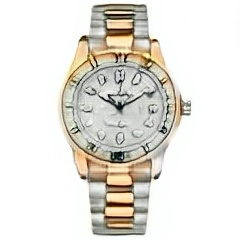

In [59]:
image_uri = "gs://auv-product-search-workshop/test_gan_watch.jpg"
display_blob_image(image_uri)

Search results:
Score(Confidence): 0.3491354286670685


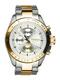

Score(Confidence): 0.3294884264469147


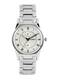

Score(Confidence): 0.32487568259239197


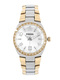

Score(Confidence): 0.31651097536087036


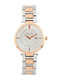

Score(Confidence): 0.31619206070899963


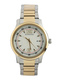

Score(Confidence): 0.3159005343914032


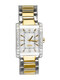

Score(Confidence): 0.30968981981277466


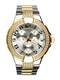

Score(Confidence): 0.3055204153060913


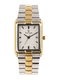

Score(Confidence): 0.2996234893798828


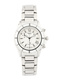

Score(Confidence): 0.29361245036125183


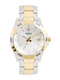

In [60]:
get_similar_products_uri_and_display(product_set_id="product_watches_0",
                                     product_category="apparel-v2",
                                     image_uri=image_uri,
                                     filter=None,
#                                      filter="style=women",
                                     threshold=0.1)

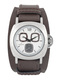

In [61]:
image_uri = "gs://auv-product-search-workshop/fashion-product-images-small/images/44970.jpg"
display_blob_image(image_uri)

Search results:
Score(Confidence): 1.0


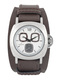

Score(Confidence): 0.42284372448921204


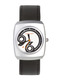

Score(Confidence): 0.39546823501586914


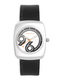

Score(Confidence): 0.3819737732410431


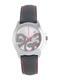

Score(Confidence): 0.37710675597190857


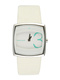

Score(Confidence): 0.36595165729522705


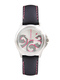

Score(Confidence): 0.3644363284111023


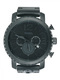

Score(Confidence): 0.3642463982105255


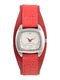

Score(Confidence): 0.3636832535266876


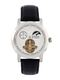

Score(Confidence): 0.36187171936035156


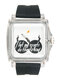

In [62]:
get_similar_products_uri_and_display(product_set_id="product_watches_0",
                                     product_category="apparel-v2",
                                     image_uri=image_uri,
                                     filter=None,
#                                      filter="style=women",
                                     threshold=0.1)